### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Tercera tarea programada 2022-I

### Parte 2 - ejercicio 2


Estudiantes: Juan Ignacio Navarro Navarro

### 1) Descripción del problema y el objetivo del ejercicio

Se desea utilizar una red neuronal recurrente LSTM utilzando pytorch para realizar un algortimo capaz de predecir la calificación dad por un comprrador. Estas calificaciones están relacionadas a el servicio de alquiler de apartamentos en una página web.

Se utilizará como base para entrenar el modelo los datos de miles de revisiones anteriores y su respectiva calificación.

El objetivo de este ejercicio es experimentar con el flujo completo de trabajo en un proyecto de aprendizaje automático para realizar análisis de sentimientos a partir de datos en lenguaje natural.

### 2) Datos utilizados en el ejercicio

Para este ejercicio se tomarán datos relacionados a las calificaciones de los usuarios usando el lenguaje natural para determinar el nivel de satisfacción con el servicio en el alquiler de apartamentos. 

Estos datos se encuentran en la siguiente dirección https://www.kaggle.com/code/wiktorbrk/trip-advisor-reviews-sentiment-analysis/notebook  de igual forma estos no son tan pesados como los del ejercicio anterior por lo que sí se incluyen en los datos en el zip de la entrega en el csv llamado tripadvisor_hotel_reviews.csv.

Note que este archivo está compuesto de aproximadamente 20500 opiniones que dividen en lo siguiente:

- review: la opinión textual de un cliente utilizando el lenguaje natural
- rating: es un número de  1 a 5 añadido por el mismo usuario. 

### 3) Cargue y prepare los datos para ser introducidos a la red LSTM

Primero se procede a importar las bilbiotecas necesarias para el ejercicio

In [27]:
# Bibliotecas requeridas
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

import matplotlib.pyplot as plt

Carga de los datos utilizando pandas

In [4]:
# Leer los datos de ejemplos
reviews = pd.read_csv("tripadvisor_hotel_reviews.csv")
print(reviews.shape)
reviews.head()

(20491, 2)


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
# Seleccionar las columnas relevantes y calcular la longitud de las oraciones
reviews = reviews[['Review', 'Rating']]
reviews.columns = ['review', 'rating']
reviews['review_length'] = reviews['review'].apply(lambda x: len(x.split()))
reviews.head(20)

,review,rating,review_length
0,nice hotel expensive parking got good deal sta...,4,87
1,ok nothing special charge diamond member hilto...,2,250
2,nice rooms not 4* experience hotel monaco seat...,3,217
3,"unique, great stay, wonderful time hotel monac...",5,89
4,"great stay great stay, went seahawk game aweso...",5,191
5,love monaco staff husband stayed hotel crazy w...,5,134
6,"cozy stay rainy city, husband spent 7 nights m...",5,101
7,"excellent staff, housekeeping quality hotel ch...",4,85
8,"hotel stayed hotel monaco cruise, rooms genero...",5,59
9,excellent stayed hotel monaco past w/e delight...,5,35


In [7]:
#Cambio de la numeración de la clasificaciones de 0 a 4
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
reviews['rating'] = reviews['rating'].apply(lambda x: zero_numbering[x])

Carga de las principales estadísitcas de los datos, note que se muestran la cantidad de datos definidos y diferentes medidas de tendencia central de los mismos

In [8]:
# Estadísticas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
reviews.describe()

,rating,review_length
count,20491.00,20491.00
mean,2.95,104.38
std,1.23,100.66
min,0.00,7.00
25%,2.00,48.00
50%,3.00,77.00
75%,4.00,124.00
max,4.00,1931.00


Tokenización y preparación de los datos para ser introducidos a la res LSTM, estos tokens son necesarios para poder distinguir entre las palabras

In [10]:
# Tokenización: proceso de separar un fragmento de texto en 
#  unidades más pequeñas llamadas tokens. 
#  Los tokens pueden ser palabras, caracteres o sub-palabras.
tok = spacy.blank("en")

def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

# Se cuenta la cantidad de ocurrencias de cada token 
# en el corpus.

#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['review']))

# Se eliminan los tokens que no ocurren con mucha frecuencia (menos de dos veces). 
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))


num_words before: 49116
num_words after: 25185


In [12]:
# Se crea el vocabulario
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)



Encodificación de las oraciones, note que se toma un máximo de 70 palabras comom máximo por cada texto

In [13]:
def encode_sentence(text, vocab2index, N=70):
    """
    Codificación de una oración antes de ser utilizada por el modelo. 
    Parámetros:
       text: el texto a procesar
       vocab2index: diccionario con el vocabulario a utilizar. 
       N: largo máximo
    """
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    
    # El get en diccionario permite definir un valor si un item no existe ("UNK").  
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    
    # Largo máximo del resultado.
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

reviews['encoded'] = reviews['review'].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
print(reviews.head())

                                              review  rating  review_length  \
0  nice hotel expensive parking got good deal sta...       3             87   
1  ok nothing special charge diamond member hilto...       1            250   
2  nice rooms not 4* experience hotel monaco seat...       2            217   
3  unique, great stay, wonderful time hotel monac...       4             89   
4  great stay great stay, went seahawk game aweso...       4            191   

                                             encoded  
0  [[2, 3, 4, 5, 6, 7, 8, 9, 3, 10, 11, 12, 13, 1...  
1  [[79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 78, ...  
2  [[2, 234, 39, 77, 74, 3, 235, 90, 7, 3, 236, 2...  
3  [[347, 11, 69, 9, 11, 348, 349, 3, 235, 11, 68...  
4  [[69, 9, 69, 9, 11, 393, 394, 395, 396, 11, 39...  


### 4) Calcule algunas estadísticas importantes

Las estadísticas de los datos se mostraron en la sección anterior antes de que se hicieran los tokens. Identificación del balanceo de las clases a continuación:

In [14]:
# Verificación de qué tan bien balanceadas están las clases.
Counter(reviews['rating'])

Counter({3: 6039, 1: 1793, 2: 2184, 4: 9054, 0: 1421})

### 7) Separación de las muestras en datos de entrenamiento y evaluación

a continuación se realiza la respectiva separación y crea un Dataser para el manejo de los datos en el modelo y la evaluación del mismo.

In [15]:
# Extracción de características y taget.
X = list(reviews['encoded'])
y = list(reviews['rating'])

# División de datos de entrenamiento y validación
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [16]:
# Definción de la clase Dataset para manejo de los datos
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [17]:
# Creación de los datasets de entrenamiento y validación
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

### 5) Defina una red recurrente LSTM 

### 6) Definición de los hiperparámetros

A continuación se muestra el modelo de la red con su respectiva función de forward

In [18]:
class LSTM_fixed_len(torch.nn.Module) :
    """
    Clase para realizar la clasificación de las oraciones. 
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size=5) :
        """
        Inicialización de la clase.
        Parámetros:
           embedding_dim: dimesionalidad del vector de palabras. 
           hidden_dim: dimensión de la capa oculta de la red. 
           vocab_size: tamaño del vocabulario.  
           tagset_size: número de clases.
        """
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)
        
        # Durante el entrenamiento, pone a cero aleatoriamente algunos de los elementos 
        # del tensor de entrada con probabilidad p utilizando muestras de una 
        # distribución de Bernoulli. Esta ha demostrado ser una técnica eficaz para la regularización.
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

### 7) Entrenamiento del modelo 

In [22]:
gen_train_loss = []
gen_val_loss = []

def train_model(model, epochs=10, lr=0.001):
    """
    Entrenamiento del modelo utilizando PyTorch.
    """
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]

        gen_train_loss.append(sum_loss)
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        gen_val_loss.append(val_loss)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [24]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)
train_model(model_fixed, epochs=10, lr=0.01)

train loss 1.369, val loss 1.353, val accuracy 0.424, and val rmse 1.508
train loss 1.294, val loss 1.318, val accuracy 0.455, and val rmse 1.535


### 9) Evaluación del modelo resultante 

In [25]:
# Validación del modelo 
average_loss, accuracy, average_rmse = validation_metrics (model_fixed, val_dl)

print ("Exactitud", accuracy)
print("Raíz del error cuadrático medio", average_rmse)

Exactitud tensor(0.4574)
Raíz del error cuadrático medio 1.3727206706106798


### 8) Grafique la curva de error con datos de entrenamiento y prueba de todas las épocas

La curva de error se muestra a continuación

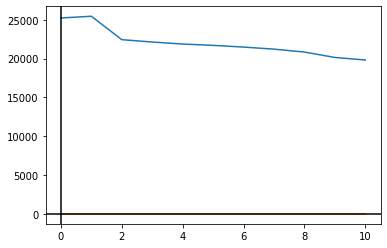

In [33]:
x = range(0, 11)

# Graficar ambas funciones
pyplot.plot(x, gen_train_loss)
pyplot.plot(x, gen_val_loss)

# Establecer el color de los ejes.
pyplot.axhline(0, color="black")
pyplot.axvline(0, color="black")
# Limitar los valores de los ejes.
#pyplot.xlim(-10, 10)
#pyplot.ylim(-10, 10)
# Guardar gráfico como imágen PNG.
# Mostrarlo.
pyplot.show()